In [1]:
import os
import numpy as np
import pandas as pd
from time import time
import sys
import copy
import pdb
import cPickle as pickle
import gzip

from transformers import *
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mode ='final'
mode ='not final'

# Load Data
import transformers
reload(transformers)
from transformers import *

pp = make_union(
    IdentityTformer(),
#     make_pipeline(AddTformer(1), BoxCoxTformer())
#     PCA(n_components=1000),
)

# Data
X = np.load('../data/X.npy')
y = np.load('../data/y.npy')
X_test = np.load('../data/X_test.npy')

pp.fit(np.r_[X, X_test])
X = pp.transform(X)
X_test = pp.transform(X_test)

k = 4
skf = StratifiedKFold(y, n_folds=k, random_state=0)

ind_train, ind_valid = list(iter(skf))[0]
X_train, X_valid = X[ind_train], X[ind_valid]
y_train, y_valid = y[ind_train], y[ind_valid]

n_feats = X_train.shape[1]
n_classes = len(np.unique(y_train))

# TO TRAIN ON ALL
if mode == 'final':
    X_train = X.copy()
    y_train = y.copy()

In [3]:
X.shape

(2013, 60)

In [4]:
def shuffle_unison(a, b):
    """ Shuffles same-length arrays `a` and `b` in unison"""
    c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
    np.random.shuffle(c)
    return c[:, :a.size//len(a)].reshape(a.shape), c[:, a.size//len(a):].reshape(b.shape)

In [5]:
# RASCO PARAMS
m = round(0.5 * n_feats)    # Size of subspace (# feats to use)
K = 128    # num of classifiers to use
J = 160    # num iterations

sub_sps = [np.random.permutation(n_feats)[:m] 
               for k in range(K)]

- need to have weights that indicate how much we want to transfer each class
- for example, in this case, we don't really want to transfer negatives, we only want to transfer over positive example of bots into the training set
- maybe weights * predicted prob of being in a class = prob of transfer - then stochastically  transfer by drawing from dist
    - randn(0,1) of size=len testing obs. if randn < weighted prob, transfer it over

In [6]:
# Init
# Consider dedicated training sets per model
# L_X = [X_train] * K
# L_y = [y_train] * K
L_X = X_train
L_y = y_train
U_X = X_test

prob_thresh = 0.999
thresh_decay = 0.0001
prob_thresh_min = 0.975
# ~160 iterations seems be the peak
# ~0.003 increase in AUC
# maybe limit the number of transfer per iteration to 1?

In [7]:
from joblib import Parallel, delayed

# clf0 = DecisionTreeClassifier
clf0 = ExtraTreeClassifier
clf1 = ExtraTreeClassifier

# clf = ExtraTreeClassifier
# clf = RandomForestClassifier

def train_model(X, y):
    model = clf()
    return model.fit(X, y)

def train_predict_model(X, y, U, val, s_i):
    if s_i < K/2:
        model = clf0(min_samples_leaf=8,
                           min_samples_split=7,
                           criterion='entropy',
                           max_depth=None,)
    else:
        model = clf1(min_samples_leaf=8,
                           min_samples_split=7,
                           criterion='entropy',
                           max_depth=None,)
    model.fit(X, y)
    U_pred = model.predict_proba(U)
    val_pred = model.predict_proba(val)
    
    return model, U_pred, val_pred

In [8]:
score_list = []
score_fn = roc_auc_score
transfer_counts = []
for j in range(J):
    print 'Iter # %d' % j
    print 'Winner thresh:', prob_thresh
    # Subspace creation
    val_preds = []
    
    ret_iter = Parallel(n_jobs=-1)(
        delayed(train_predict_model)(
            L_X[:, sub_sp], L_y, 
            U_X[:, sub_sp], 
            X_valid[:, sub_sp],
            s_i,
        ) 
        for s_i, sub_sp in enumerate(sub_sps))
    
    models, U_preds, val_preds = zip(*ret_iter)
    val_pred_ens = np.array(val_preds).mean(axis=0)
    score_ens = score_fn(y_valid, val_pred_ens[:, 1])
    score_list.append(score_ens)
    print 'Ensemble score:', score_ens
        
    U_pred_avg = np.array(U_preds).mean(axis=0)
    max_probs = U_pred_avg.max(axis=1)
    U_y_pred = np.argmax(U_pred_avg, axis=1)
    
    win_inds = max_probs > prob_thresh
    L_X, L_y = shuffle_unison(
            np.r_[L_X, U_X[win_inds, :]],
            np.r_[L_y, U_y_pred[win_inds]],)
    
    U_X = np.delete(U_X, np.where(win_inds), axis=0)
    print 'Transferred unlabeled observations: %d' % win_inds.sum()
    print 'Transfer distribution:', [list(U_y_pred[win_inds]).count(cc) 
                                     for cc in range(n_classes)]
    transfer_counts.append(win_inds.sum())
    print 'Cumulative transfer:', np.array(transfer_counts).sum()
    
    if not win_inds.sum():
        prob_thresh -= thresh_decay
    sys.stdout.flush()

Iter # 0
Winner thresh: 0.999
Ensemble score: 0.916478918571
Transferred unlabeled observations: 2
Transfer distribution: [2, 0]
Cumulative transfer: 2
Iter # 1
Winner thresh: 0.999
Ensemble score: 0.91865143225
Transferred unlabeled observations: 157
Transfer distribution: [157, 0]
Cumulative transfer: 159
Iter # 2
Winner thresh: 0.999
Ensemble score: 0.921065336337
Transferred unlabeled observations: 51
Transfer distribution: [51, 0]
Cumulative transfer: 210
Iter # 3
Winner thresh: 0.999
Ensemble score: 0.915915674284
Transferred unlabeled observations: 31
Transfer distribution: [31, 0]
Cumulative transfer: 241
Iter # 4
Winner thresh: 0.999
Ensemble score: 0.915030576118
Transferred unlabeled observations: 23
Transfer distribution: [23, 0]
Cumulative transfer: 264
Iter # 5
Winner thresh: 0.999
Ensemble score: 0.917846797554
Transferred unlabeled observations: 29
Transfer distribution: [29, 0]
Cumulative transfer: 293
Iter # 6
Winner thresh: 0.999
Ensemble score: 0.91663984551
Transfe

In [156]:
len(models)

32

In [183]:
q = models[0]
q.n_features_

37

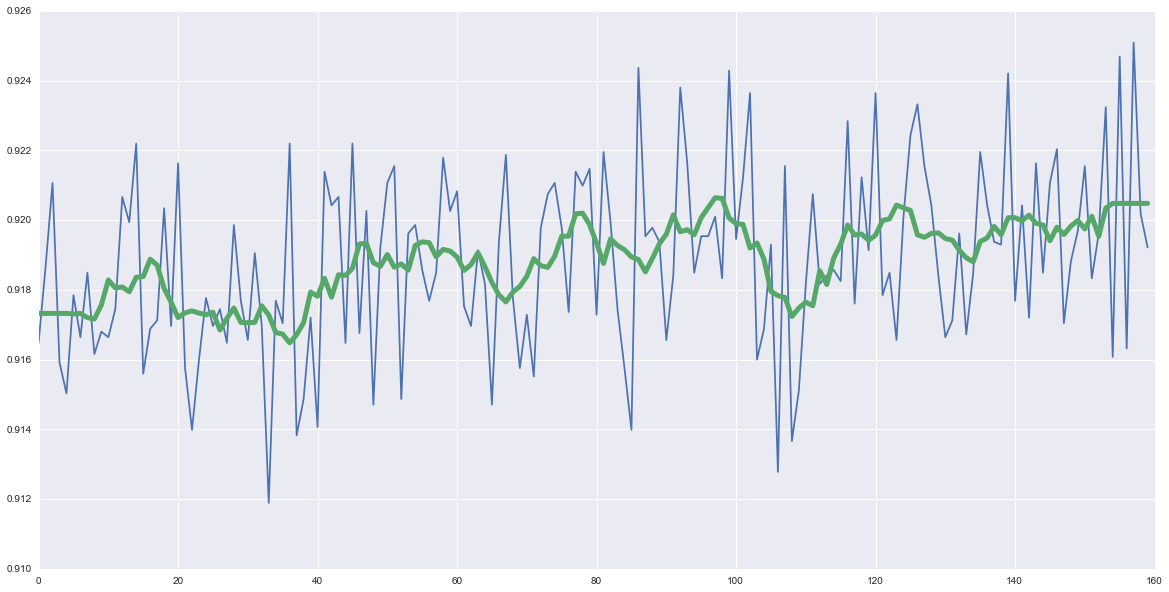

In [30]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = np.arange(len(score_list))
win_sz = 10
smooth = movingaverage(score_list, win_sz)
smooth[:win_sz/2] = smooth[win_sz/2+1]
smooth[-win_sz/2:] = smooth[-win_sz/2-1]
plt.plot(score_list)
plt.plot(smooth, lw=5)

In [135]:
np.unique(np.array(sub_sps).flatten()).shape

(74,)

#PREDICTION

In [27]:
sub = pd.read_csv('../data/sampleSubmission.csv')

In [28]:
y_pred_list = []
for s_i, sub_sp in enumerate(sub_sps):
    X_test_sub = X_test[:, sub_sp]
    model = models[s_i]
    y_pred_list.append(model.predict_proba(X_test_sub)[:, 1])

y_pred_avg = np.array(y_pred_list).mean(axis=0)

In [34]:
sub['prediction'] = y_pred_avg
sub.to_csv('../submissions/rasco160-et128_id-boxcox.csv', index=False)

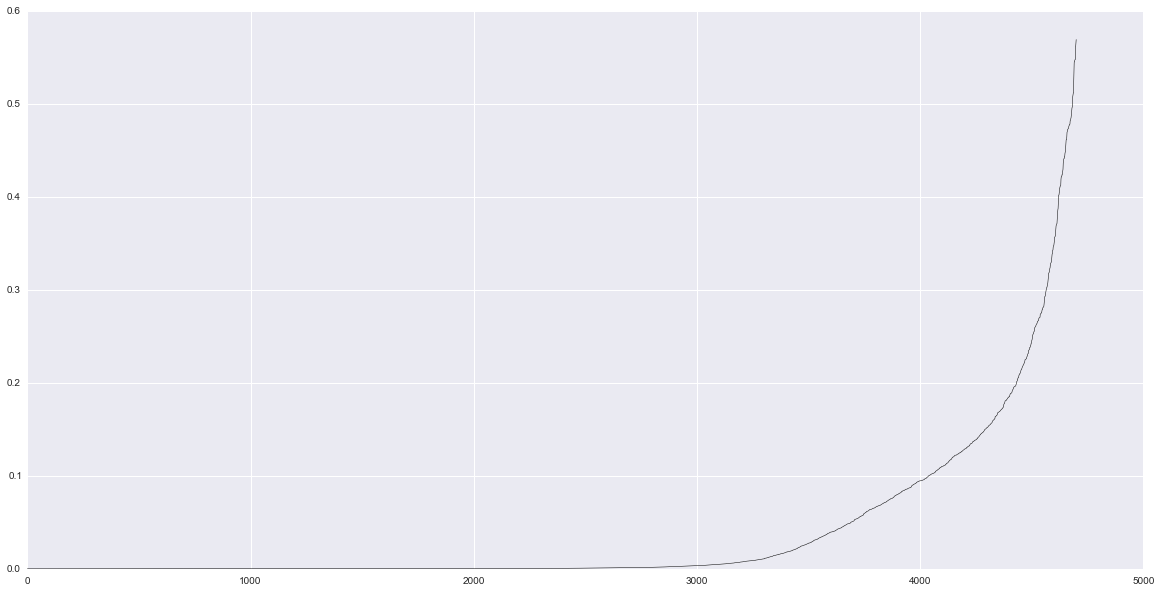

In [33]:

plt.figure(figsize=(20,10))
# plt.plot(np.array(y_pred_list).T, alpha=0.8);
plt.plot(y_pred_avg, lw=0.5, c='black');

(array([ 3738.,   386.,   238.,   116.,    78.,    38.,    27.,    32.,
           35.,    12.]),
 array([  0.        ,   7.28499168,  14.56998336,  21.85497504,
         29.13996672,  36.4249584 ,  43.70995008,  50.99494177,
         58.27993345,  65.56492513,  72.84991681]),
 <a list of 10 Patch objects>)

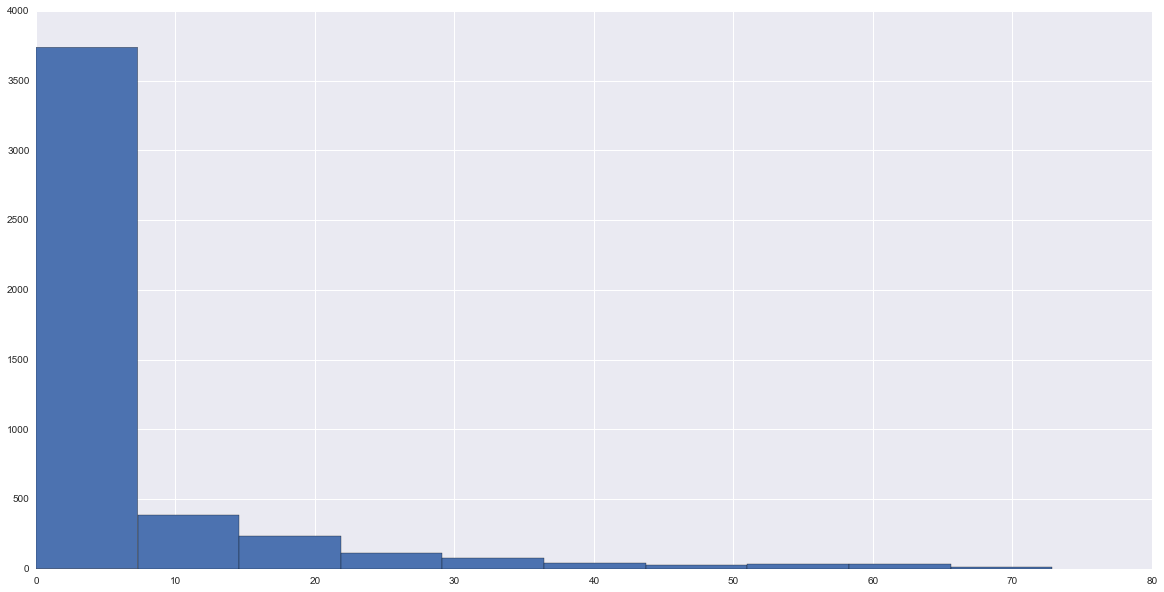

In [31]:
plt.figure(figsize=(20,10))
y_pred_sum = np.array(y_pred_list).sum(axis=0)
plt.hist(y_pred_sum)